# CASE STUDY

## CODE

### 1)Import Packages

In [70]:
import pypsa
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import warnings
import subprocess
from shapely.errors import ShapelyDeprecationWarning
import logging

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("pypsa.pf").setLevel(logging.WARNING)
plt.rc("figure", figsize=(10, 8))

In [71]:
excel_file_path = r"C:\Users\dell\Documents\1\Amprion.xlsx"


### 2)Create a network and set Snapshots

In [72]:
# Create a new PyPSA network
network= pypsa.Network()
network.set_snapshots(range(8760))  # Solve for a year 365*24

### 3)Add Buses

In [73]:
# Read excel file which contains Non renewable generators data
bus_data = pd.read_excel(excel_file_path, sheet_name='buses')

In [74]:
for index,row in bus_data.iterrows():
    network.add(
    "Bus",
    name=row['bus'],
    v_nom=row['v_nom'],
    carrier=row['carrier'],
    x=row['x'],
    y=row['y']
)
    
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
Amprion,380.0,,6.953101,50.935173,AC,,1.0,0.0,inf,PQ,,


### 4)Add generators

In [75]:
generators = pd.read_excel(excel_file_path,sheet_name="generators" )

network.madd(
"Generator",
    names= generators.generator,
    bus=list(generators.bus),
    carrier=list(generators.carrier),
    p_nom=list(generators.p_nom),      
    p_nom_max=list(generators.p_nom_A),     
    #p_nom_max=list(generators.p_nom_B),    
    #p_nom_max=list(generators.p_nom_C),    
    p_nom_extendable=list(generators.p_nom_extandable),
    marginal_cost=list(generators.marginal_cost),
    efficiency=list(generators.efficiency),
    capital_cost=list(generators.capital_cost)
    ) 

network.generators

,bus,carrier,p_nom,p_nom_max,p_nom_extendable,marginal_cost,efficiency,capital_cost,control,type,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
A_Biomasse,Amprion,biomass,1507.0,800.0,False,75.000,0.40,220900.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
A_Coal,Amprion,coal,7702.0,5300.0,False,33.708,0.30,130000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
A_Lignite,Amprion,lignite,10915.0,3300.0,False,31.960,0.40,190000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
A_Natural gas,Amprion,gas,14824.0,11600.0,False,36.568,0.40,40000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
A_Onshore Wind,Amprion,wind,10554.0,14300.0,True,0.000,1.00,118200.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
A_Pumped storage,Amprion,hydro,200.0,300.0,True,3.000,0.95,200000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
A_Solar,Amprion,solar,11067.0,13000.0,True,0.000,1.00,60000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
A_runofriver,Amprion,hydro,0.0,0.0,True,3.000,0.94,90000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
A_therconventionals,Amprion,fuel,2178.0,800.0,False,35.000,0.30,100000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [76]:
PV_timeseries=pd.read_excel(excel_file_path,sheet_name='PV_timeseries')
wind_timeseries=pd.read_excel(excel_file_path,sheet_name='wind_timeseries')

In [77]:
network.generators_t.p_max_pu["A_Solar"] = list(PV_timeseries.p_nom_pu_solar_Amprion)
network.generators_t.p_max_pu["A_Onshore Wind"] = list(wind_timeseries.p_nom_pu_Amprion)



### 5)Add load

### Added by Parag

In [78]:
'''
You can add your all loads in a timeseries in columns and add load using network.add function like mentioned in the following code:
To verify whether the timeseries of the load data (p_set) is added properly, use:  `network.loads_t.p_set`  this command
'''

"""
# Read excel file which contains Non renewable generators data
def add_consumers(filename, index_col):
    try:
        load = pd.read_(filename,index_col=index_col)
    except pd.errors.EmptyDataError:
        print("The CSV file is empty.")
        return

    for load_name in list(load.columns.unique()):
        network.add("Load",
        f"{load_name}",
        bus=load_name,
        p_set=load[load_name].tolist()
        )

    return network.loads_t.p_set.head(5)    
"""

'\n# Read excel file which contains Non renewable generators data\ndef add_consumers(filename, index_col):\n    try:\n        load = pd.read_(filename,index_col=index_col)\n    except pd.errors.EmptyDataError:\n        print("The CSV file is empty.")\n        return\n\n    for load_name in list(load.columns.unique()):\n        network.add("Load",\n        f"{load_name}",\n        bus=load_name,\n        p_set=load[load_name].tolist()\n        )\n\n    return network.loads_t.p_set.head(5)    \n'

In [79]:
demand = pd.read_excel(excel_file_path,sheet_name="load_hourly" )
'''
network.add("Load", "Amprion", bus="Amprion", p_set=demand["Amprion"])
network.add("Load", "Tennet", bus="Tennet", p_set=demand["TenneT"])
network.add("Load", "TransnetBW", bus="TransnetBW", p_set=demand["TransnetBW"])
network.add("Load", "50Hertz", bus="50Hertz", p_set=demand["50Hertz"])
'''
#'''Scenario A
network.add("Load", "Amprion", bus="Amprion", p_set=demand["load_A_Amprion"])
#'''

'''Scenario B
network.add("Load", "Amprion", bus="Amprion", p_set=demand["load_B_Amprion"])
'''

'''Scenario C
network.add("Load", "Amprion", bus="Amprion", p_set=demand["load_C_Amprion"])
'''

'Scenario C\nnetwork.add("Load", "Amprion", bus="Amprion", p_set=demand["load_C_Amprion"])\n'

<Axes: xlabel='snapshot', ylabel='MW'>

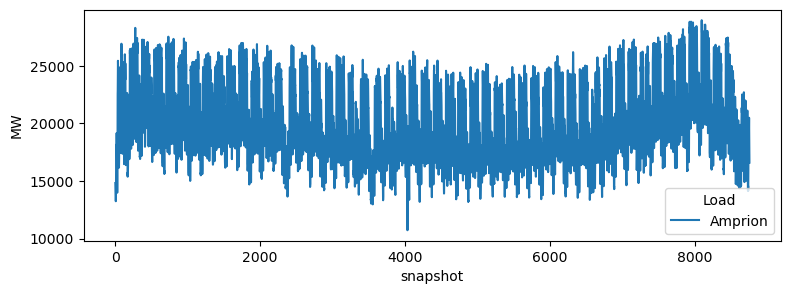

In [80]:
network.loads_t.p_set.plot(figsize=(9,3), ylabel="MW")

### 6)Add Lines

In [81]:
lines=pd.read_excel(excel_file_path,sheet_name='lines',header=0)
lines.head()

,name,bus0,s_nom,efficiency,s_nom_extendable
0,1,Amprion,10000,1,True


In [82]:
for X, row in lines.iterrows():
    network.add("Line",
    name=row['name'],
    bus0=row['bus0'],
    s_nom=row['s_nom'],
    x=row['efficiency'],
    s_nom_extendable=row['s_nom_extendable'] 
    )
network.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
1,Amprion,,,1.0,0.0,0.0,0.0,10000.0,0.0,True,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 7)Add links

links = pd.read_excel(excel_file_path, sheet_name='links')
links.head()

for X, row in links.iterrows():
    network.add("Link",
    name=row['name'],
    bus0=row['bus0'],
    bus1=row['bus1'],
    p_nom=row['p_nom'],
    p_nom_extendable=row['p_nom_extendable'],
    efficiency=row['efficiency'],
    capital_cost=row['capital_cost'] )
network.links

### 8)Add carriers

In [83]:
Carriers = pd.read_excel(excel_file_path,sheet_name="co2_emissions" )
Carriers.tail()

,name,co2_emissions
4,hydro,0.000
5,solar,0.000
6,biomass,0.000
7,fuel,0.202
8,reaction,0.000


In [84]:
for X, row in Carriers.iterrows():
    network.add(
        "Carrier",
        name=row['name'],
        co2_emissions=row['co2_emissions']
    )
network.carriers

attribute,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
coal,0.354,,,inf,0.0
gas,0.202,,,inf,0.0
lignite,0.364,,,inf,0.0
wind,0.000,,,inf,0.0
hydro,0.000,,,inf,0.0
solar,0.000,,,inf,0.0
biomass,0.000,,,inf,0.0
fuel,0.202,,,inf,0.0
reaction,0.000,,,inf,0.0


In [85]:

network.add("Store", "battery storage2", bus="Amprion", e_cyclic=True, e_nom=10000000.0)


In [86]:
network.add(
    "StorageUnit",
    "battery storage2",
    bus="Amprion",
    p_nom=100000000,
    max_hours=10,  # energy storage in terms of hours at full power
)

### 9)CO2 emissions

network.add("GlobalConstraint", "co2_limit", sense="<=", constant=438000000)

## RESULTS

### 1)Optimize

In [87]:
network.optimize(solver_name='glpk')

Index(['1'], dtype='object', name='Line')
Index(['1'], dtype='object', name='Line')
Index(['1'], dtype='object', name='Line')
Index(['1'], dtype='object', name='Line')


ValueError: negative column index found

### 2)Margianl price

In [ ]:
network.buses_t.marginal_price

In [ ]:
network.generators.p_nom_opt.plot.bar(ylabel="MW", figsize=(8, 3))

In [ ]:
network.generators_t.p.sum().plot.bar(ylabel="Total generation MW")

### 3)Lines snapshot

In [ ]:
network.lines_t.p0

### 4)Gen assign

In [ ]:
gen = network.generators.assign(g=network.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum()
gen

### 5)Flow

In [ ]:
flow = pd.Series(10, index=network.branches().index)
flow

### 6)Geo. graph

In [ ]:
plot_graph=network.plot(
    bus_sizes=gen/20000,
    bus_colors={"biomass":"black","coal":"blue","gas":"pink","hydro":"cadetblue","lignite":"yellow","solar":"orange","wind":"midnightblue"},
    margin=1,
    line_widths=3,
    link_widths=0,
    flow=flow,
    color_geomap=True,
    projection=ccrs.EqualEarth(),
    line_colors=network.lines_t.p0.mean().abs(),
)
plt.colorbar(plot_graph[2], fraction=0.04, pad=0.004, label="Flow in MW")
plt.show()

In [ ]:
# Your DataFrame df
df = pd.concat(
    [
        network.generators_t.p.loc[0],
        network.links_t.p0.loc[0],
        network.loads_t.p.loc[0],
    ],
    keys=["Generators", "Links", "Line"],
    names=["Component", "index"],
).reset_index(name="Production")

# Plotting using PyPSA
fig, ax = plt.subplots(figsize=(50, 10))

# Plot generators
df_generators = df[df["Component"] == "Generators"]
ax.bar(df_generators["index"], df_generators["Production"], label="Generators")

# Plot links
df_links = df[df["Component"] == "Links"]
ax.bar(df_links["index"], df_links["Production"], label="Links")

# Plot loads
df_loads = df[df["Component"] == "Line"]
ax.bar(df_loads["index"], df_loads["Production"], label="Line")

# Customize the plot
ax.set_xlabel("Component")
ax.set_ylabel("Production (MW)")
ax.set_title("Power Production by Component")
ax.legend()

# Show the plot
plt.show()


## ADDITIONAL

### -)Storages

In [ ]:
"""
def add_stores(filename, header):
    try:
        stores = pd.read_csv(filename, header=header)
    except pd.errors.EmptyDataError:
        print("The CSV file is empty.")
        return
        
    for index, row in stores.iterrows():
        network.add(
            "Store",
            name=row['name'],
            e_initial=row['e_initial'],
            e_nom=row['e_nom'],
            marginal_cost=row['marginal_cost'],
            bus=row['bus'],
            e_cyclic=row['e_cyclic'],
            e_nom_extendable=row['e_nom_extendable'],
        )
    return network.stores
"""

add_stores('stores.csv',0)

### -)Global constraints

In [ ]:
#network.lopf()